In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from io import StringIO
import pandas as pd

from battleship.agents import RandomCaptain, MAPCaptain, ProbabilisticCaptain, CodeSpotterModel, LLMDecisionCaptain, EIGAutoCaptain
from battleship.board import Board
from battleship.game import BattleshipGame
from battleship.agents import CacheMode

In [ ]:
stage_df = pd.read_csv("/home/ubuntu/repo_battleship/temp/gold_annotations_partial.csv")
round_df = pd.read_csv("/home/ubuntu/repo_battleship/battleship/experiments/collaborative/battleship-final-data/round.csv")
goldAnnotations=["answer", "ambiguous", "contextual", "unanswerable"]

board_ids = round_df[["id", "board_id"]]

filtered_stage_df = stage_df[
    [
        "roundID",
        "index",
        "questionID",
        "messageText",
        "messageType",
        "occTiles",
        "goldAnswer",
    ]
]
df = filtered_stage_df.merge(
    board_ids, left_on="roundID", right_on="id", how="inner"
)

In [ ]:
def game_completed(hits, misses, occTiles, board_id):
    def mask(board_array):
        return (board_array != -1) & (board_array != 0)
    if hits + misses > 40:
        return False
    else:
        return np.all(mask(occTiles) == mask(Board.convert_to_numeric(Board.from_trial_id(board_id).to_symbolic_array())))

question_counts_df = (
    df[df["messageType"] == "question"]
    .groupby("roundID")
    .size()
    .reset_index(name="question_number")
)

df = df.merge(question_counts_df, on="roundID", how="inner")
result = df.loc[df.groupby('roundID')['index'].idxmax()][['roundID','occTiles', 'board_id','question_number']]
result = result[result["occTiles"] != str(np.full((8, 8), -1).tolist()).replace(" ", "")] #ugly!
data = []
for roundID, occTiles, board_id in zip(result["roundID"], result["occTiles"], result["board_id"]):
    occTiles = np.array(eval(occTiles))
    misses = np.sum(occTiles == 0)
    hits = np.sum((occTiles != -1) & (occTiles != 0))
    data.append({
        "captainType": "human",
        "boardId": board_id,
        "hits": hits,
        "misses": misses,
        "gameCompleted": game_completed(hits, misses, occTiles, board_id),
        "questionsAsked": result[result["roundID"] == roundID]["question_number"].values[0]
    })
human_results_df = pd.DataFrame(data)
human_results_df

In [ ]:
human_good = human_results_df[human_results_df["gameCompleted"]]
human_good

In [ ]:
from matplotlib import pyplot as plt

moves = human_good["hits"] + human_good["misses"]
plt.figure(figsize=(8, 6))
plt.hist(moves, edgecolor='black')
plt.xlabel("Number of Moves")
plt.ylabel("Frequency")
plt.title("Histogram of Moves in Human Results")
plt.show()

In [ ]:

board_ids = ["B"+str(i).zfill(2) for i in range(1, 19)]

eig_spotter = CodeSpotterModel(
                    board_id="B01", 
                    board_experiment="collaborative",
                    model_string="openai/gpt-4o",
                    temperature=None,
                    use_cot=True,
                )

captains = {"RandomCaptain": RandomCaptain(seed=42), 
            "MAPCaptain":MAPCaptain(seed=42, n_samples=100), 
            "EIGAutoCaptain":EIGAutoCaptain(seed=42,
                                                samples=1000,
                                                model_string="openai/gpt-4o",
                                                spotter=eig_spotter,
                                                use_cot=False,
                                                cache_mode=CacheMode.WRITE_ONLY
                                            )}
seeds = range(1,7+1)

seeds = [1]
board_ids = ["B01", "B02"]

data = []
for cap_name, captain in captains.items():
    print("Starting with captain", cap_name)
    for idx, seed in enumerate(seeds):
        for board_id in board_ids:
            if cap_name == "EIGAutoCaptain":
                eig_spotter.board_id = board_id
            captain.seed = seed
            
            board = Board.from_trial_id(board_id)
            game = BattleshipGame(
                board_target=board,
                max_questions=1,
                max_moves=1,
                captain=captain,
                spotter=CodeSpotterModel(
                                        board_id,
                                        "collaborative",
                                        cache_mode=CacheMode.WRITE_ONLY,
                                        model_string="openai/gpt-4o",
                                        temperature=None,
                                        use_cot=True
                                        ),
            )
            game.play()
            hits = game.hits
            misses = game.misses
            data.append({
                "captainType": cap_name,
                "boardId": board_id,
                "hits": hits,
                "misses": misses,
                "gameCompleted": game.is_won(),
                "questionsAsked": game.question_count
            })

agent_results_df = pd.DataFrame(data)


In [ ]:
game

In [ ]:
results_df = pd.concat([human_results_df, agent_results_df])
results_df["precision"] = results_df["hits"] / (results_df["hits"] + results_df["misses"])
results_df

In [3]:
results_df = pd.read_csv("/home/ubuntu/repo_battleship/temp/total_results_names.csv")
results_df["moves"] = results_df["hits"] + results_df["misses"]
results_df["moves"] = list(map(lambda x: min(40,x), results_df["moves"].tolist()))
results_df

,captainType,boardId,hits,misses,gameCompleted,questionsAsked,precision,moves
0,Human,B03,13,17,True,13,0.433333,30
1,Human,B04,12,31,False,3,0.279070,40
2,Human,B03,12,28,False,4,0.300000,40
3,Human,B16,18,11,True,8,0.620690,29
4,Human,B12,9,23,True,1,0.281250,32
...,...,...,...,...,...,...,...,...
513,LLM+COT,B14,13,27,False,15,0.325000,40
514,LLM+COT,B15,11,24,True,15,0.314286,35
515,LLM+COT,B16,16,24,False,15,0.400000,40
516,LLM+COT,B17,9,31,False,15,0.225000,40


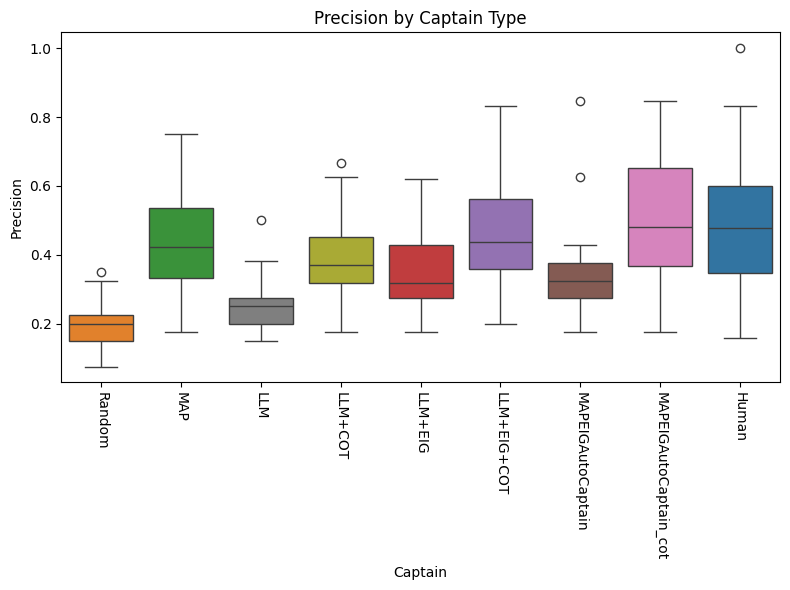

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=results_df,
    x='captainType',
    y='precision',
    order = ["Random", "MAP", "LLM", "LLM+COT", "LLM+EIG", "LLM+EIG+COT", "MAPEIGAutoCaptain", "MAPEIGAutoCaptain_cot", "Human"],
    hue='captainType',
)
plt.title('Precision by Captain Type')
plt.ylabel('Precision')
plt.xlabel('Captain')
plt.xticks(rotation=270)
plt.tight_layout()
plt.show()

In [6]:
# Group by 'captainType' and calculate the required statistics
summary_df = results_df.groupby('captainType').agg(
    precision_mean=('precision', 'mean'),
    precision_std=('precision', 'std'),
    completed_mean=('gameCompleted', 'mean'),
    completed_std=('gameCompleted', 'std'),
    misses_mean=('misses', 'mean'),
    misses_std=('misses', 'std')
).reset_index()

summary_df

,captainType,precision_mean,precision_std,completed_mean,completed_std,misses_mean,misses_std
0,Human,0.478040,0.160599,0.878261,0.328415,15.886957,8.990019
1,LLM,0.257495,0.087410,0.222222,0.427793,28.611111,5.259601
2,LLM+COT,0.384393,0.132818,0.722222,0.460889,20.888889,7.977091
3,LLM+EIG,0.349182,0.111940,0.583333,0.500000,23.472222,7.145373
4,LLM+EIG+COT,0.473113,0.160673,0.886364,0.321038,15.750000,7.655747
5,MAP,0.424562,0.127937,0.912698,0.283403,18.285714,6.917638
6,MAPEIGAutoCaptain,0.352046,0.158820,0.388889,0.501631,23.944444,8.446874
7,MAPEIGAutoCaptain_cot,0.484387,0.200573,0.823529,0.392953,16.235294,10.195155
8,Random,0.194643,0.059465,0.000000,0.000000,32.214286,2.378595


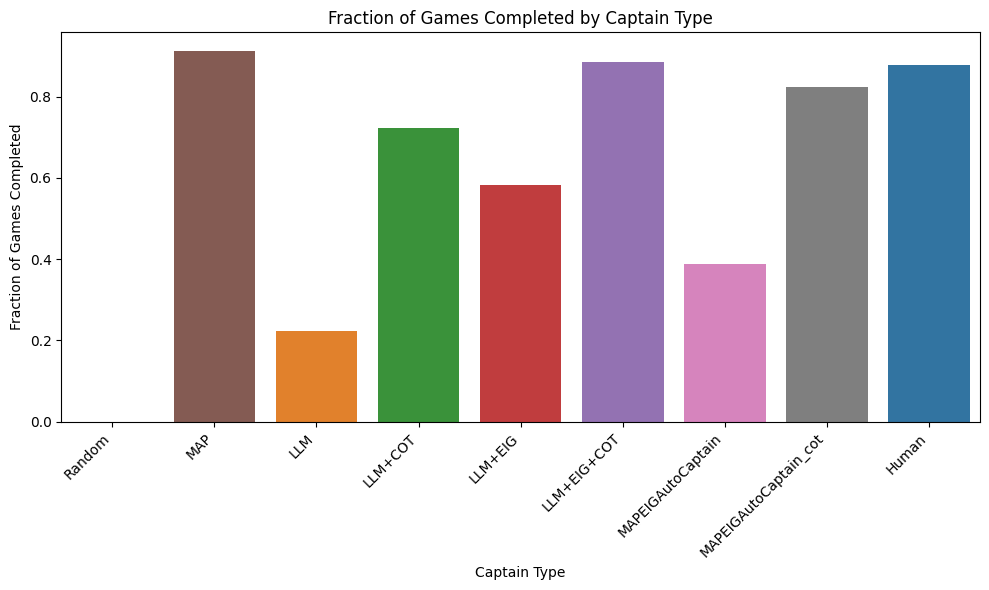

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

order = ["Random", "MAP", "LLM", "LLM+COT", "LLM+EIG", "LLM+EIG+COT", "MAPEIGAutoCaptain", "MAPEIGAutoCaptain_cot", "Human"]

plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df.reset_index(),
    x="captainType",
    y="completed_mean",
    order=order,
    hue='captainType',
    capsize=0.1
)
plt.xlabel("Captain Type")
plt.ylabel("Fraction of Games Completed")
plt.title("Fraction of Games Completed by Captain Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()